In [1]:
import glob
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import cv2
import PIL.Image as Image

from utils.util_flow import load_calib_cam_to_cam, read_calib_file
from dataloader.depthloader import disparity_loader, triangulation
from utils.flowlib import read_flow, flow_to_image
from utils.util_flow import write_flow, readPFM, save_pfm

from dataloader import kitti15list_val_lidar as DA

In [2]:
# helper functions
def load_velodyne_points(file_name):
    # adapted from https://github.com/hunse/kitti
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points

def sub2ind(matrixSize, rowSub, colSub):
    m, n = matrixSize
    return rowSub * (n-1) + colSub - 1

def ext_depth(line, kitti_dir):
    """
    extract depth from point clouds in two consequtive frames
    """
    date, seq, fr = line.split(' ')
    cam = 2
    calib_dir = '%s/%s/'%(kitti_dir,date)
    cam2cam = read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
    velo2cam = read_calib_file(calib_dir + 'calib_velo_to_cam.txt')
    velo2cam = np.hstack((velo2cam['R'].reshape(3,3), velo2cam['T'][..., np.newaxis]))
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3,:3] = cam2cam['R_rect_00'].reshape(3,3)
    P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3,4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)
    
    # depth1
    velo = load_velodyne_points('%s/%s/%s/velodyne_points/data/%s.bin'%(kitti_dir,date,seq,fr))
    velo = velo[velo[:, 0] >= 0, :]
    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]
    velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:,0] < shape[1]) & (velo_pts_im[:,1] < shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((shape))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds==dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth<0] = 0 
    depth1=depth.copy()

    # depth2
    velo = load_velodyne_points('%s/%s/%s/velodyne_points/data/%010d.bin'%(kitti_dir,date,seq,int(fr)+1))
    velo = velo[velo[:, 0] >= 0, :]
    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]
    velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:,0] < shape[1]) & (velo_pts_im[:,1] < shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((shape))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds==dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth<0] = 0
    depth2=depth.copy()
    
    return depth1,depth2

# scene flow dataset to raw dataset mapping
with open('/data/gengshay/kitti_scene/devkit/mapping/train_mapping.txt') as f:
    lines = [i.strip() if len(i.strip())>0 else None for i in f.readlines()]
    
frame_to_lidar = {}
for it,l in enumerate(lines):
    frame_to_lidar[it] = l

In [3]:
prefix='./precomputed/'
kitti_raw_path='/data/gengshay/KITTI' # replace with yours
kitti_sf_path='/ssd/kitti_scene/training/' # replace with yours
modelname='lidar-kitti-train'

method='expansion' # over {expansion, flownet3, osf, prsm}

dc_err = []
ttc_err1 = []
ttc_err2 = []
ttc_err5 = []
f3d_epe = []
f3d_out = []
tt = []
test_left_img, test_right_img ,flow_paths= DA.dataloader(kitti_sf_path)
for fp in sorted(test_left_img):
    print(fp)
    fid = fp.split('/')[-1].split('_')[0]

    # load ground-truth
    gt_disp0 = disparity_loader('%s/disp_occ_0/%s_10.png'%(kitti_sf_path,fid))
    gt_disp1 = disparity_loader('%s/disp_occ_1/%s_10.png'%(kitti_sf_path,fid))
    gt_flow = read_flow('%s/flow_occ/%s_10.png'%(kitti_sf_path,fid))
    gt_logdc = np.log(gt_disp0/gt_disp1)
    d1mask = gt_disp0>0
    d2mask = gt_disp1>0
    flmask = np.logical_and(np.logical_and(d1mask,d2mask),gt_flow[:,:,2])
    
    if method=='expansion':
        disp0 = disparity_loader('%s/%s/2015/%s_10_disp.pfm'%(prefix,modelname,fid))
        disp1 = disparity_loader('%s/%s/2015/%s_11_disp.pfm'%(prefix,modelname,fid))
        flow = read_flow('%s/%s/2015/%s_10.png'%(prefix,modelname,fid))
    elif method=='flownet3':
        disp0 = disparity_loader('/data/gengshay/sceneflow_results/dn-css-ft/disp_0/%s_10.png'%(fid))
        disp1 = disparity_loader('/data/gengshay/sceneflow_results/dn-css-ft/disp_1/%s_10.png'%(fid))
        flow = read_flow('/data/gengshay/sceneflow_results/dn-css-ft/flow/%s_10.png'%(fid))
    elif method=='osf':
        disp0 = disparity_loader('/data/gengshay/sceneflow_results/osf/disp_0/%s_10.png'%(fid))
        disp1 = disparity_loader('/data/gengshay/sceneflow_results/osf/disp_1/%s_10.png'%(fid))
        flow = read_flow('/data/gengshay/sceneflow_results/osf/flow/%s_10.png'%(fid))
    elif method=='prsm':
        disp0 = disparity_loader('/home/gengshay/code/SF/PRSM/solvePWRSMulti/2Frames/disp_0/%s_10.png'%(fid))
        disp1 = disparity_loader('/home/gengshay/code/SF/PRSM/solvePWRSMulti/2Frames/disp_1/%s_10.png'%(fid))
        flow = read_flow('/home/gengshay/code/SF/PRSM/solvePWRSMulti/2Frames/flow/%s_10.png'%(fid))
    logdc = np.clip(np.log(disp0/np.clip(disp1,1e-8,np.inf)),-np.log(2),np.log(2))
        
    shape = d1mask.shape
    x0,y0=np.meshgrid(range(shape[1]),range(shape[0]))
    x0=x0.astype(np.float32)
    y0=y0.astype(np.float32)
    
    
    # metrics for expansion and time-to-contact
    dcerr = np.abs(gt_logdc-logdc)
    dcerr[~flmask]=0
    
    gt_ttc = 0.1/(1-np.exp(gt_logdc))
    ttc = 0.1/(1-np.exp(logdc))
    ttcmask = np.logical_and(flmask, gt_ttc>0)
    ttcerr1 = (gt_ttc<1) != (ttc<1)
    ttcerr2 = (gt_ttc<2) != (ttc<2)
    ttcerr5 = (gt_ttc<5) != (ttc<5)
    ttcerr1[~ttcmask]=0
    ttcerr2[~ttcmask]=0
    ttcerr5[~ttcmask]=0

    
    # metrics for lidar scene flow 
    d,_ = ext_depth(frame_to_lidar[int(fid)], kitti_raw_path)
    dmask = np.logical_and(d>0,flmask)
    
    ints = load_calib_cam_to_cam('%s/calib/%s.txt'%(kitti_sf_path,fid))
    fl = ints['K_cam2'][0,0]
    bl = ints['b20']-ints['b30']
    cx = ints['K_cam2'][0,2]
    cy = ints['K_cam2'][1,2]

    gt_P0 = triangulation(gt_disp0, x0, y0, bl=bl, fl = fl, cx = cx, cy = cy)
    gt_P1 = triangulation(gt_disp1, x0 + gt_flow[:,:,0], y0 + gt_flow[:,:,1], bl=bl, fl = fl, cx = cx, cy = cy)
    gt_f3d = gt_P1-gt_P0
    
    P0 = triangulation(bl*fl/d, x0, y0, bl=bl, fl = fl, cx = cx, cy = cy)
    P1 = triangulation(bl*fl/d/np.exp(logdc), x0 + flow[:,:,0], y0 + flow[:,:,1], bl=bl, fl = fl, cx = cx, cy = cy)
    f3d = P1-P0
    
    f3depe = np.linalg.norm((gt_f3d-f3d)[:3],ord=None, axis=0).reshape(shape)
    f3depe[~dmask]=0
    f3dout = (np.logical_or(f3depe > 0.3, f3depe / np.linalg.norm((gt_f3d)[:3],ord=None, axis=0).reshape(shape)  > 0.1))
    f3dout[~dmask]=0
    
    
    dc_err.append(dcerr[flmask])
    ttc_err1.append(ttcerr1[ttcmask])
    ttc_err2.append(ttcerr2[ttcmask])
    ttc_err5.append(ttcerr5[ttcmask])
    f3d_epe.append(f3depe[dmask])
    f3d_out.append(f3dout[dmask])

/ssd/kitti_scene/training/image_2/000113_10.png


<ipython-input-3-22b051606f36>:24: RuntimeWarning: invalid value encountered in true_divide
  gt_logdc = np.log(gt_disp0/gt_disp1)
<ipython-input-3-22b051606f36>:57: RuntimeWarning: divide by zero encountered in true_divide
  gt_ttc = 0.1/(1-np.exp(gt_logdc))
<ipython-input-3-22b051606f36>:58: RuntimeWarning: divide by zero encountered in true_divide
  ttc = 0.1/(1-np.exp(logdc))
/home/gengshay/code/expansion/dataloader/depthloader.py:51: RuntimeWarning: divide by zero encountered in true_divide
  depth = bl*fl / disp # 450px->15mm focal length
<ipython-input-3-22b051606f36>:80: RuntimeWarning: invalid value encountered in subtract
  gt_f3d = gt_P1-gt_P0
<ipython-input-3-22b051606f36>:82: RuntimeWarning: divide by zero encountered in true_divide
  P0 = triangulation(bl*fl/d, x0, y0, bl=bl, fl = fl, cx = cx, cy = cy)
<ipython-input-3-22b051606f36>:83: RuntimeWarning: divide by zero encountered in true_divide
  P1 = triangulation(bl*fl/d/np.exp(logdc), x0 + flow[:,:,0], y0 + flow[:,:,1],

/ssd/kitti_scene/training/image_2/000114_10.png
/ssd/kitti_scene/training/image_2/000115_10.png
/ssd/kitti_scene/training/image_2/000116_10.png
/ssd/kitti_scene/training/image_2/000117_10.png
/ssd/kitti_scene/training/image_2/000118_10.png
/ssd/kitti_scene/training/image_2/000119_10.png
/ssd/kitti_scene/training/image_2/000120_10.png
/ssd/kitti_scene/training/image_2/000121_10.png
/ssd/kitti_scene/training/image_2/000122_10.png
/ssd/kitti_scene/training/image_2/000123_10.png
/ssd/kitti_scene/training/image_2/000124_10.png
/ssd/kitti_scene/training/image_2/000125_10.png
/ssd/kitti_scene/training/image_2/000126_10.png
/ssd/kitti_scene/training/image_2/000127_10.png
/ssd/kitti_scene/training/image_2/000128_10.png
/ssd/kitti_scene/training/image_2/000129_10.png


<ipython-input-3-22b051606f36>:24: RuntimeWarning: divide by zero encountered in true_divide
  gt_logdc = np.log(gt_disp0/gt_disp1)


/ssd/kitti_scene/training/image_2/000130_10.png
/ssd/kitti_scene/training/image_2/000131_10.png
/ssd/kitti_scene/training/image_2/000132_10.png
/ssd/kitti_scene/training/image_2/000141_10.png
/ssd/kitti_scene/training/image_2/000142_10.png
/ssd/kitti_scene/training/image_2/000143_10.png
/ssd/kitti_scene/training/image_2/000144_10.png
/ssd/kitti_scene/training/image_2/000145_10.png
/ssd/kitti_scene/training/image_2/000146_10.png
/ssd/kitti_scene/training/image_2/000147_10.png
/ssd/kitti_scene/training/image_2/000148_10.png
/ssd/kitti_scene/training/image_2/000149_10.png
/ssd/kitti_scene/training/image_2/000150_10.png
/ssd/kitti_scene/training/image_2/000155_10.png
/ssd/kitti_scene/training/image_2/000157_10.png
/ssd/kitti_scene/training/image_2/000158_10.png
/ssd/kitti_scene/training/image_2/000159_10.png
/ssd/kitti_scene/training/image_2/000160_10.png
/ssd/kitti_scene/training/image_2/000161_10.png
/ssd/kitti_scene/training/image_2/000162_10.png
/ssd/kitti_scene/training/image_2/000163

In [4]:
print('dc:%f'%np.concatenate(dc_err).mean())
print('ttc-err-1:%f'%(np.concatenate(ttc_err1).mean()*100))
print('ttc-err-2:%f'%(np.concatenate(ttc_err2).mean()*100))
print('ttc-err-5:%f'%(np.concatenate(ttc_err5).mean()*100))
print('f3d-mean:%f'%np.concatenate(f3d_epe).mean())
print('f3d-std:%f'%np.concatenate(f3d_epe).std())
print('f3d-out:%f'%np.concatenate(f3d_out).astype(float).mean())

dc:0.006120
ttc-err-1:3.736111
ttc-err-2:5.339045
ttc-err-5:4.702143
f3d-mean:0.120488
f3d-std:0.334676
f3d-out:0.359701


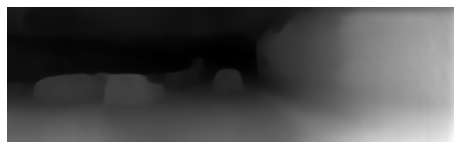

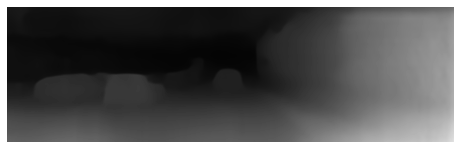

In [5]:
# visualizations
plt.figure(figsize=(8,3)); plt.axis('off')
plt.imshow(disp0,cmap='gray')
plt.figure(figsize=(8,3)); plt.axis('off')
plt.imshow(disp1,cmap='gray',vmax=100,vmin=0)

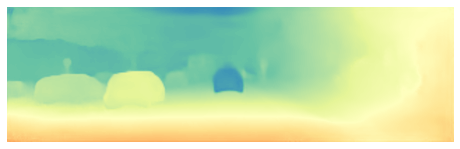

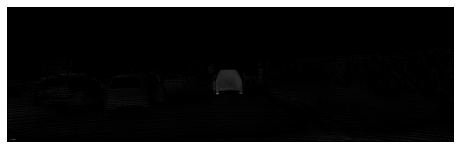

In [6]:
plt.figure(figsize=(8,3)); plt.axis('off')
plt.imshow(logdc,cmap='Spectral',vmax=0.05,vmin=-0.3)
plt.figure(figsize=(8,3)); plt.axis('off')
plt.imshow(dcerr,cmap='gray',vmin=0,vmax=0.1)

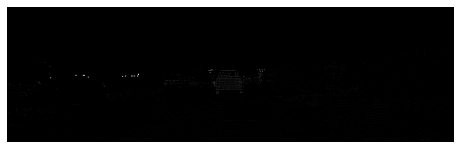

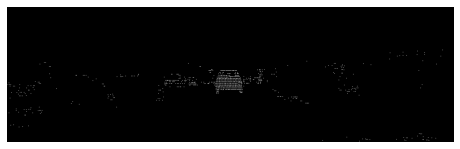

In [7]:
plt.figure(figsize=(8,3)); plt.axis('off')
plt.imshow(f3depe,vmax=0.5, cmap='gray')
plt.figure(figsize=(8,3)); plt.axis('off')
plt.imshow(f3dout,vmax=0.5, cmap='gray')